In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.image_rendering_data_module import ImageRenderingDataModule
from imap.model.nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load images

In [3]:
color_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/1305031464.959763.png"))
depth_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/1305031464.952471.png"))

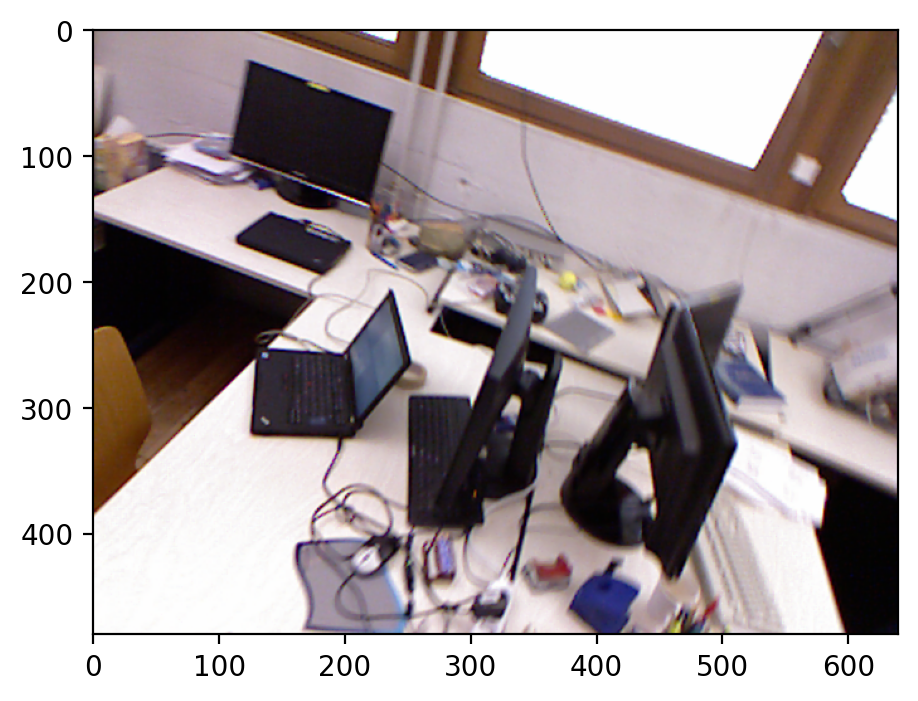

In [4]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

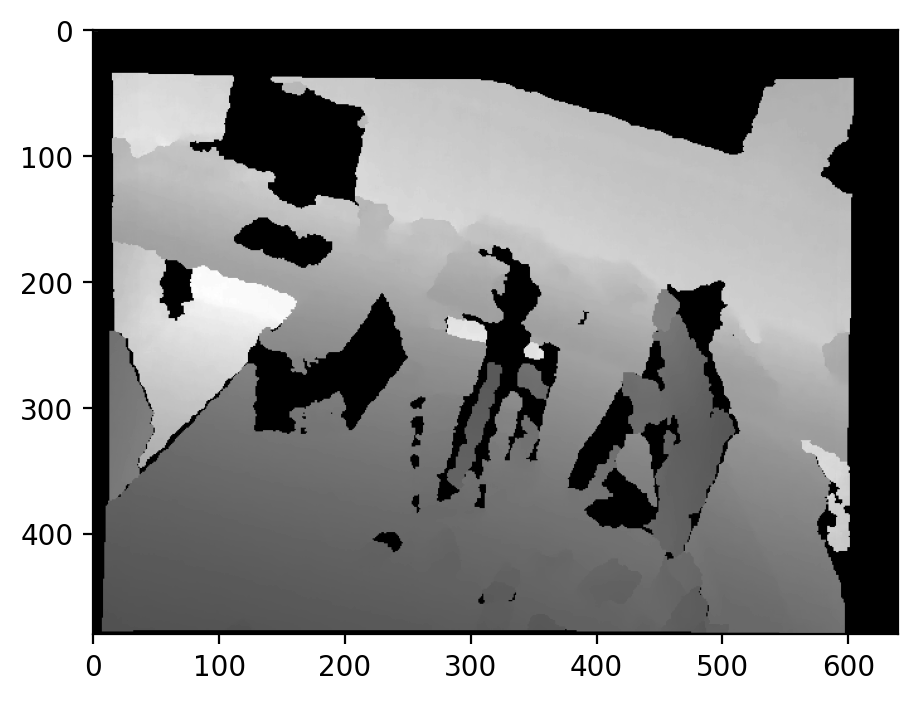

In [5]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 5000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

In [87]:
dataset_params = {'dataset_path': "/media/mikhail/Data3T/tum_rgbd", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [88]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(lr=0.005),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    encoding_sigma=25,
    optimize_positions=False,
    minimal_depth=0.01,
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

# Test map builder

In [89]:
from imap.slam.imap_data_loader import IMAPDataLoader
from imap.slam.active_sampler import ActiveSampler
from imap.slam.keyframe_validator import KeyframeValidator
from imap.slam.imap_map_builder import IMAPMapBuilder
from imap.data.tum_frame_loader import TUMFrameLoader
from imap.slam.optimized_frame import OptimizedFrame

In [90]:
dataset_path = "/media/mikhail/Data3T/tum_rgbd"
scene_name = "rgbd_dataset_freiburg1_desk"
association_file_name = "data_association_file.txt"
camera_info = data_module._dataset._camera_info
map_builder_data_loader = IMAPDataLoader(20, 200, camera_info)

sampler_data_loader = IMAPDataLoader(1, 200, camera_info)
sampler = ActiveSampler(sampler_data_loader, 4, 1)

keyframe_validator = KeyframeValidator(0.1, 0.5)
builder = IMAPMapBuilder(model, map_builder_data_loader, sampler, keyframe_validator)
frames = TUMFrameLoader(dataset_path, scene_name, association_file_name, range(0, 100, 1))

initial_position = np.eye(4)[:3, :]
frames = [OptimizedFrame(x, initial_position) for x in frames]

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [91]:
previous_frame = frames[0]
previous_frame.position.requires_grad_(False)
builder.set_current_frame(previous_frame)
builder.step()
for frame in tqdm(frames[1:]):
    frame.position.data = previous_frame.position.detach().clone().requires_grad_(True)
    builder.set_current_frame(frame)
    builder.step()
    previous_frame = frame

Map builder step
Start training
Final loss = 1.2978854179382324
Keyframe validator criterion = 0.35714285714285715
Keyframe is validated = True


  0%|          | 0/99 [00:00<?, ?it/s]

Map builder step
Start training
Final loss = 0.7539311051368713
Keyframe validator criterion = 0.41818181818181815
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6766696572303772
Keyframe validator criterion = 0.44642857142857145
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6218798160552979
Keyframe validator criterion = 0.4491017964071856
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.6011030077934265
Keyframe validator criterion = 0.48148148148148145
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5405977368354797
Keyframe validator criterion = 0.47058823529411764
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5644991397857666
Keyframe validator criterion = 0.4397590361445783
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.567654550075531
Keyframe validator criterion = 0.43636363636363634
Keyframe is validated = 

Final loss = 0.515333890914917
Keyframe validator criterion = 0.6737588652482269
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5130248069763184
Keyframe validator criterion = 0.6
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4588035047054291
Keyframe validator criterion = 0.684931506849315
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.48634111881256104
Keyframe validator criterion = 0.5486111111111112
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5507638454437256
Keyframe validator criterion = 0.5345911949685535
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5066620111465454
Keyframe validator criterion = 0.5436241610738255
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.508788526058197
Keyframe validator criterion = 0.5608108108108109
Keyframe is validated = False
Map builder step
Start training
Final los

In [92]:
# [x.matrix_position for x in frames]

In [93]:
# [x.frame.ground_truth_position[:3, :3] @ frames[0].frame.ground_truth_position[:3, :3].T for x in frames]

In [94]:
# [x.frame.ground_truth_position for x in frames]

In [115]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
#             go.Scatter3d(x=shown_predicted_trajectory[:, 0],
#                          y=shown_predicted_trajectory[:, 1],
#                          z=shown_predicted_trajectory[:, 2],
#                          mode="markers",
#                          name="predicted",
#                          marker={
#                              "size": 2
#                          }),
#             go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
#                          y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
#                          z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
#                          mode="lines",
#                          name="errors")
        ]
    )
    fig.show()



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

In [118]:
# estimated_trajectory = np.array([x[:3,3] for x in tracked_positions])
# estimated_trajectory = np.array([x.position[:3, 3] for x in frames if x.position is not None])
show_trajectories(
    np.array([x.matrix_position[:3, 3] for x in frames]), None
#                   np.array([x.frame.ground_truth_position[:3,3] / 10 for x in frames]),
#                   estimated_trajectory
)

In [119]:
# estimated_trajectory = np.array([x[:3,3] for x in tracked_positions])
# estimated_trajectory = np.array([x.position[:3, 3] for x in frames if x.position is not None])
show_trajectories(
#     np.array([x.matrix_position[:3, 3] for x in frames]), None
                  np.array([x.frame.ground_truth_position[:3,3] / 10 for x in frames]), None
#                   estimated_trajectory
)

# Show the results

In [95]:
from scipy.spatial.transform import Rotation

In [96]:
def get_position(translation, rotation):
    matrix_position = np.eye(4)
    matrix_position[:3, 3] = translation
    matrix_position[:3, :3] = Rotation.from_euler("xyz", rotation).as_matrix()
    return matrix_position

In [103]:
scale = 1
y, x = np.meshgrid(range(color_image.shape[0] // scale), range(color_image.shape[1] // scale))                       
pixels = np.array([x, y], dtype=np.float32).T * scale
pixels = torch.tensor(pixels).cuda().reshape(-1, 2)
# position = get_position(np.array([0, 0, 0]), np.array([0, 0, 0]))
# position = data_module._dataset._positions[0]
position = frames[20].matrix_position
# delta_position = get_position(np.array([0, 0, -1]), np.array([0.3, 0, 0]))
delta_position = get_position(np.array([0, 0, -0.05]), np.array([0, 0.5, 0]))
# position = position @ delta_position
positions = torch.repeat_interleave(torch.tensor(position.astype(np.float32))[None], pixels.shape[0],
                                  dim=0).cuda()

In [104]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
# model = model.cuda()
model.train()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

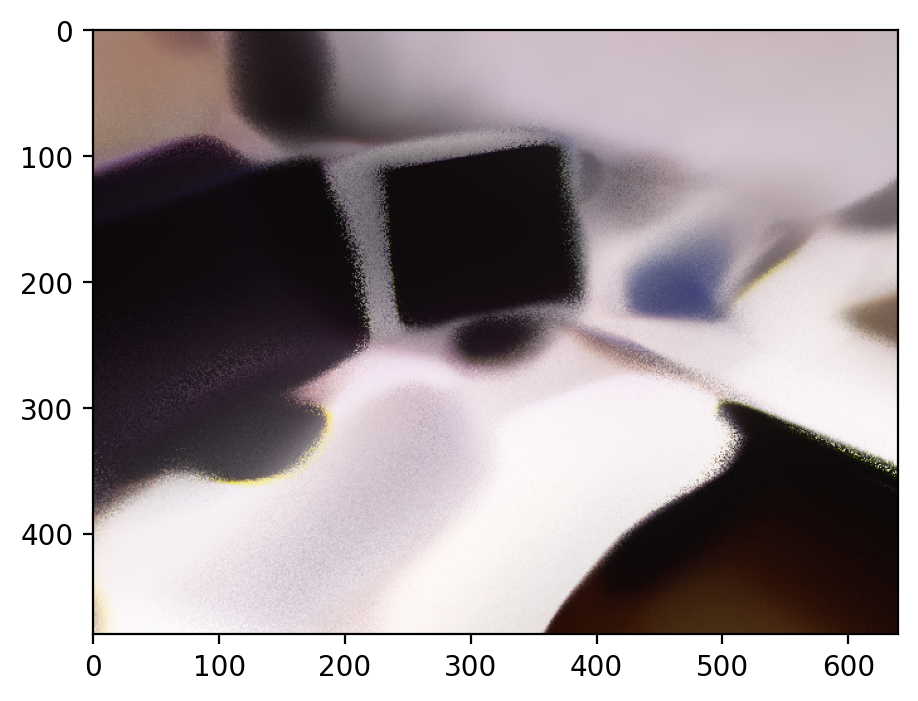

In [105]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

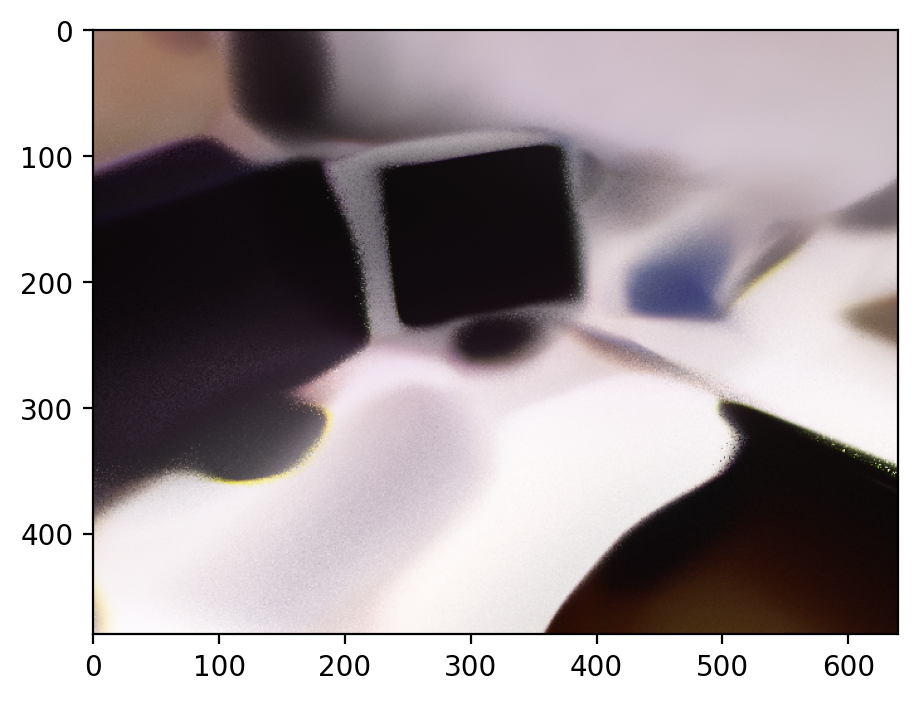

In [106]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

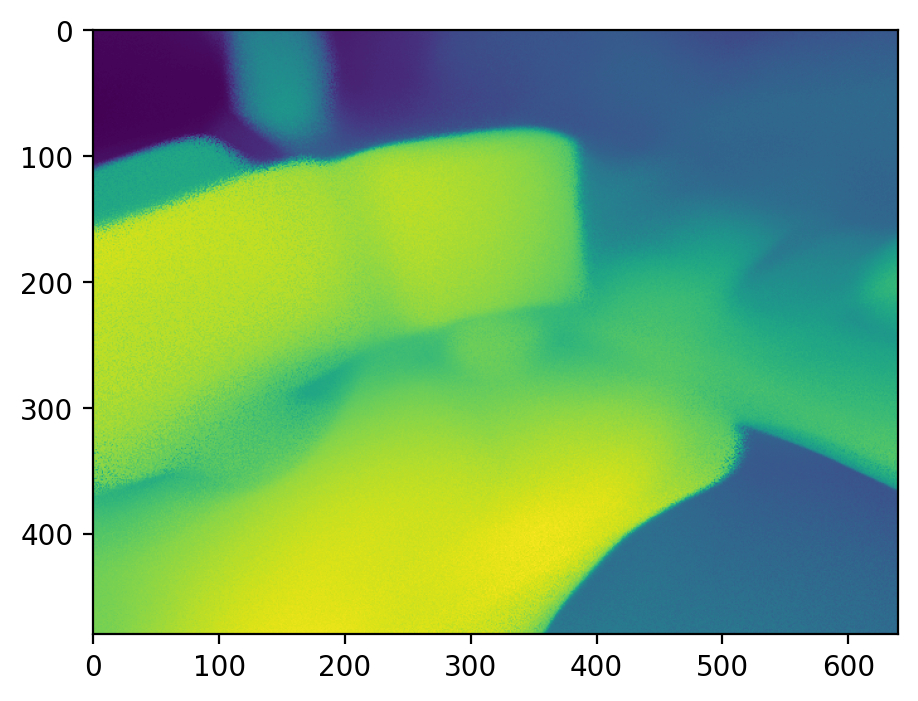

In [107]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

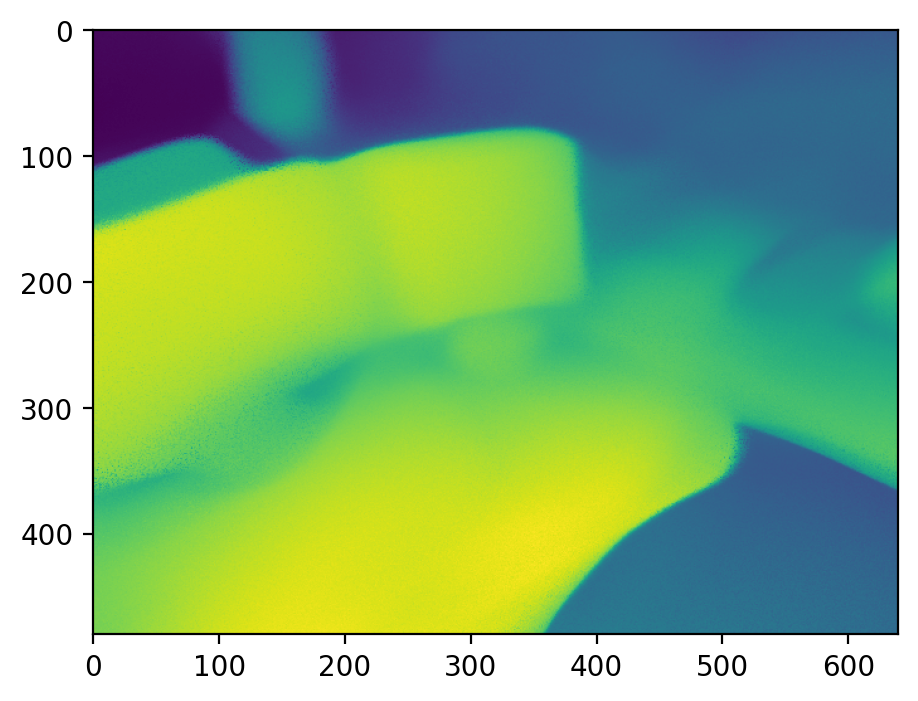

In [108]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)